In [1]:
!nvidia-smi

Thu May 13 21:19:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  On   | 00000000:04:00.0 Off |                  N/A |
| 23%   31C    P8     7W / 250W |  10757MiB / 11178MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  On   | 00000000:05:00.0 Off |                  N/A |
| 24%   

In [1]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
import os
import time
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from sodapy import Socrata

In [5]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

In [60]:
!mkdir data_flow

mkdir: cannot create directory ‘data_flow’: File exists


In [61]:
from datetime import datetime
today = datetime.today().strftime('%Y-%m-%d')
print(today)

2021-05-27


In [6]:
#Incidencia - Regio

In [62]:
# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("analisi.transparenciacatalunya.cat", None)

# Example authenticated client (needed for non-public datasets):
# client = Socrata(analisi.transparenciacatalunya.cat,
#                  MyAppToken,
#                  userame="user@example.com",
#                  password="AFakePassword")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("qwj8-xpvk",limit=500000) #623z-r97q

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)
print(results_df.shape)

(115242, 8)


In [63]:
results_df["data"] = pd.to_datetime(results_df["data"])
print(results_df.columns)

results_df["numcasos"] = pd.to_numeric(results_df["numcasos"])

#results_df.sort_values("data",ascending=True).tail()
dfCasosReg = results_df[["data","regiosanitariacodi","regiosanitariadescripcio","numcasos"]].groupby([
    "data","regiosanitariacodi","regiosanitariadescripcio"]).sum()
print(dfCasosReg.columns)
dfCasosReg = dfCasosReg.reset_index()
dfCasosReg.to_csv("data_flow/CASOS_REG" + today +".csv",index=False)
print(dfCasosReg.shape)
dfCasosReg

Index(['data', 'edatrang', 'numcasos', 'regiosanitariacodi',
       'regiosanitariadescripcio', 'resultatcoviddescripcio', 'sexecodi',
       'sexedescripcio'],
      dtype='object')
Index(['numcasos'], dtype='object')
(4401, 4)


,data,regiosanitariacodi,regiosanitariadescripcio,numcasos
0,2020-03-01,0000,No classificat,1
1,2020-03-01,7803,BARCELONA CIUTAT,1
2,2020-03-02,0000,No classificat,2
3,2020-03-02,6700,CATALUNYA CENTRAL,2
4,2020-03-02,7801,METROPOLITANA SUD,1
5,2020-03-02,7803,BARCELONA CIUTAT,2
6,2020-03-03,0000,No classificat,1
7,2020-03-03,6400,GIRONA,1
8,2020-03-03,6700,CATALUNYA CENTRAL,1
9,2020-03-03,7801,METROPOLITANA SUD,3


In [64]:
#Vacunacio - Regio

In [65]:
# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("analisi.transparenciacatalunya.cat", None)

# Example authenticated client (needed for non-public datasets):
# client = Socrata(analisi.transparenciacatalunya.cat,
#                  MyAppToken,
#                  userame="user@example.com",
#                  password="AFakePassword")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("tp23-dey4",limit=10000000) #623z-r97q

In [66]:
#'BioNTech / Pfizer' 'No administrada' 'Moderna / Lonza'
#'Oxford / AstraZeneca' 'J&J / Janssen'
fabDosi = dict()
fabDosi["BioNTech / Pfizer"] = 2
fabDosi["Moderna / Lonza"] = 2
fabDosi["Oxford / AstraZeneca"] = 2
fabDosi["J&J / Janssen"] = 1

In [67]:
# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)
results_df["regio_codi"][results_df["regio_codi"].isnull()] = 0

print(results_df.columns)
print(results_df.shape)
print(results_df["regio"].unique())
print(results_df["regio_codi"].unique())
print(results_df["fabricant"].unique())
print(results_df["dosi"].unique())

Index(['abs', 'abs_codi', 'aga', 'aga_codi', 'data', 'dosi', 'edat',
       'fabricant', 'no_vacunat', 'recompte', 'regio', 'regio_codi', 'sector',
       'sector_codi', 'sexe', 'sexe_codi'],
      dtype='object')
(870251, 16)
['BARCELONA CIUTAT' 'METROPOLITANA NORD' 'METROPOLITANA SUD' 'GIRONA'
 'CATALUNYA CENTRAL' 'CAMP DE TARRAGONA' 'LLEIDA' "TERRES DE L'EBRE"
 'ALT PIRINEU I ARAN' 'No classificat']
['7803' '7802' '7801' '6400' '6700' '6200' '6100' '6300' '7100' 0]
['Moderna / Lonza' 'BioNTech / Pfizer' 'Oxford / AstraZeneca'
 'No administrada' 'J&J / Janssen']
['1' '2']


In [68]:
results_df["no_vacunat"][results_df["no_vacunat"].isnull()] = 0
results_df["no_vacunat"][results_df["no_vacunat"]!=0] = 1

print(results_df["no_vacunat"].unique())

results_df["data"] = pd.to_datetime(results_df["data"])
results_df["recompte"] = pd.to_numeric(results_df["recompte"])
results_df["dosi"] = pd.to_numeric(results_df["dosi"])
results_df["no_vacunat"] = pd.to_numeric(results_df["no_vacunat"])

dfCasosVac = results_df[["data","regio_codi","regio","dosi","no_vacunat","recompte"]].groupby([
    "data","regio_codi","regio","dosi","no_vacunat"]).sum()
print(dfCasosVac.shape)
dfCasosVac = dfCasosVac.reset_index()
dfCasosVac = dfCasosVac[dfCasosVac["no_vacunat"]==0]
dfCasosVac.to_csv("data_flow/CASOS_VAC" + today +".csv",index=False)
print(dfCasosVac.shape)
dfCasosVac

[0 1]
(4175, 1)
(2578, 6)


,data,regio_codi,regio,dosi,no_vacunat,recompte
0,2020-12-27,0,No classificat,1,0,1
1,2020-12-27,6100,LLEIDA,1,0,66
3,2020-12-27,6200,CAMP DE TARRAGONA,1,0,112
4,2020-12-27,6300,TERRES DE L'EBRE,1,0,81
5,2020-12-27,6400,GIRONA,1,0,76
6,2020-12-27,6700,CATALUNYA CENTRAL,1,0,85
7,2020-12-27,7100,ALT PIRINEU I ARAN,1,0,79
8,2020-12-27,7801,METROPOLITANA SUD,1,0,84
9,2020-12-27,7802,METROPOLITANA NORD,1,0,161
10,2020-12-27,7803,BARCELONA CIUTAT,1,0,59


In [129]:
dfCasosVac["regio_codi"].unique()

array([0, '6100', '6200', '6300', '6400', '6700', '7100', '7801', '7802',
       '7803'], dtype=object)

In [69]:
dfCasosVac["regio"].unique()

array(['No classificat', 'LLEIDA', 'CAMP DE TARRAGONA',
       "TERRES DE L'EBRE", 'GIRONA', 'CATALUNYA CENTRAL',
       'ALT PIRINEU I ARAN', 'METROPOLITANA SUD', 'METROPOLITANA NORD',
       'BARCELONA CIUTAT'], dtype=object)

In [70]:
print(dfCasosVac["recompte"][dfCasosVac["no_vacunat"]==1].sum())
print(dfCasosVac["recompte"][dfCasosVac["no_vacunat"]==0].sum())
print(dfCasosVac["recompte"][np.logical_and(dfCasosVac["no_vacunat"]==0,dfCasosVac["dosi"]==1)].sum())
print(dfCasosVac["recompte"][np.logical_and(dfCasosVac["no_vacunat"]==0,dfCasosVac["dosi"]==2)].sum())

0
4006889
2782481
1224408


In [ ]:
#LOAD

In [ ]:
#Merge, remove null and na imputation

In [6]:
today = "2021-12-02"

In [7]:
#Vacunats

(6966, 6)
Index(['data', 'regio_codi', 'regio', 'dosi', 'no_vacunat', 'recompte'], dtype='object')
[6100 6200 6300 6400 6700 7100 7801 7802 7803    0]
['LLEIDA' 'CAMP DE TARRAGONA' "TERRES DE L'EBRE" 'GIRONA'
 'CATALUNYA CENTRAL' 'ALT PIRINEU I ARAN' 'METROPOLITANA SUD'
 'METROPOLITANA NORD' 'BARCELONA CIUTAT' 'No classificat']
6961    2021-11-30
6962    2021-11-30
6963    2021-11-30
6964    2021-11-30
6965    2021-11-30
Name: data, dtype: object
679
[1 2 3]
(727, 6)


<AxesSubplot:xlabel='data'>

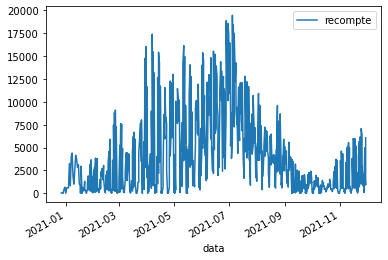

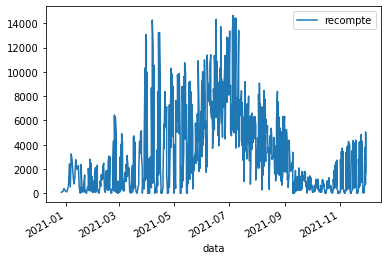

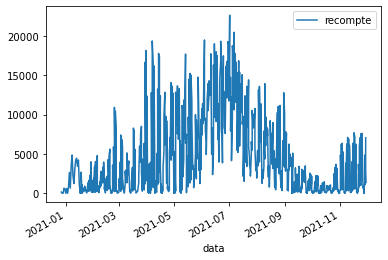

In [8]:
dfVac = pd.read_csv("data_flow/CASOS_VAC" + today + ".csv")

print(dfVac.shape)
print(dfVac.columns)

print(dfVac["regio_codi"].unique())
print(dfVac["regio"].unique())
print(dfVac["data"].iloc[-5:])
print((dfVac["regio_codi"]==0).sum())
print(dfVac["dosi"].unique())

dfVac["recompte"] = pd.to_numeric(dfVac["recompte"])
dfVac["data"] = pd.to_datetime(dfVac["data"])
dfVac.sort_values("data",ascending=True, inplace=True)

print(dfVac[dfVac["regio_codi"]==7803].shape)
dfVac[dfVac["regio_codi"]==7803][["data","recompte"]].plot(x="data",y="recompte") #BCN CENTRE
dfVac[dfVac["regio_codi"]==7801][["data","recompte"]].plot(x="data",y="recompte") #BCN SUD
dfVac[dfVac["regio_codi"]==7802][["data","recompte"]].plot(x="data",y="recompte") #BCN NORD


In [9]:
# calculate cases by computing the mean of the last 7 days reported cases

dfVac_r_6200_v1 = dfVac[np.logical_and(dfVac["regio_codi"]==6200, dfVac["dosi"]==1)][["data","recompte"]]
dfVac_r_6200_v2 = dfVac[np.logical_and(dfVac["regio_codi"]==6200, dfVac["dosi"]==2)][["data","recompte"]]

dfVac_r_7803_v1 = dfVac[np.logical_and(dfVac["regio_codi"]==7803, dfVac["dosi"]==1)][["data","recompte"]]
dfVac_r_7803_v2 = dfVac[np.logical_and(dfVac["regio_codi"]==7803, dfVac["dosi"]==2)][["data","recompte"]]

dfVac_r_6700_v1 = dfVac[np.logical_and(dfVac["regio_codi"]==6700, dfVac["dosi"]==1)][["data","recompte"]]
dfVac_r_6700_v2 = dfVac[np.logical_and(dfVac["regio_codi"]==6700, dfVac["dosi"]==2)][["data","recompte"]]

dfVac_r_7801_v1 = dfVac[np.logical_and(dfVac["regio_codi"]==7801, dfVac["dosi"]==1)][["data","recompte"]]
dfVac_r_7801_v2 = dfVac[np.logical_and(dfVac["regio_codi"]==7801, dfVac["dosi"]==2)][["data","recompte"]]

dfVac_r_6400_v1 = dfVac[np.logical_and(dfVac["regio_codi"]==6400, dfVac["dosi"]==1)][["data","recompte"]]
dfVac_r_6400_v2 = dfVac[np.logical_and(dfVac["regio_codi"]==6400, dfVac["dosi"]==2)][["data","recompte"]]

dfVac_r_7802_v1 = dfVac[np.logical_and(dfVac["regio_codi"]==7802, dfVac["dosi"]==1)][["data","recompte"]]
dfVac_r_7802_v2 = dfVac[np.logical_and(dfVac["regio_codi"]==7802, dfVac["dosi"]==2)][["data","recompte"]]

dfVac_r_6100_v1 = dfVac[np.logical_and(dfVac["regio_codi"]==6100, dfVac["dosi"]==1)][["data","recompte"]]
dfVac_r_6100_v2 = dfVac[np.logical_and(dfVac["regio_codi"]==6100, dfVac["dosi"]==2)][["data","recompte"]]

dfVac_r_7100_v1 = dfVac[np.logical_and(dfVac["regio_codi"]==7100, dfVac["dosi"]==1)][["data","recompte"]]
dfVac_r_7100_v2 = dfVac[np.logical_and(dfVac["regio_codi"]==7100, dfVac["dosi"]==2)][["data","recompte"]]

dfVac_r_6300_v1 = dfVac[np.logical_and(dfVac["regio_codi"]==6300, dfVac["dosi"]==1)][["data","recompte"]]
dfVac_r_6300_v2 = dfVac[np.logical_and(dfVac["regio_codi"]==6300, dfVac["dosi"]==2)][["data","recompte"]]

dfVac_r_0_v1 = dfVac[np.logical_and(dfVac["regio_codi"]==0, dfVac["dosi"]==1)][["data","recompte"]]
dfVac_r_0_v2 = dfVac[np.logical_and(dfVac["regio_codi"]==0, dfVac["dosi"]==2)][["data","recompte"]]

print(dfVac_r_0_v1.shape, dfVac_r_7803_v1.shape,dfVac_r_6700_v1.shape,dfVac_r_7801_v1.shape,
     dfVac_r_6400_v1.shape,dfVac_r_7802_v1.shape,dfVac_r_6200_v1.shape,dfVac_r_6100_v1.shape,
     dfVac_r_7100_v1.shape,dfVac_r_6300_v1.shape)

(327, 2) (338, 2) (335, 2) (335, 2) (333, 2) (338, 2) (332, 2) (323, 2) (310, 2) (318, 2)


In [10]:
dfVacAll = None
dfVacAll = pd.merge(dfVac_r_6200_v1,dfVac_r_7803_v1,how="left", on="data",suffixes=("_r_6200_v1","_r_7803_v1"))

dfVacAll = pd.merge(dfVacAll, dfVac_r_6700_v1,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_6700_v1'}, inplace = True)

dfVacAll = pd.merge(dfVacAll,dfVac_r_7801_v1,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_7801_v1'}, inplace = True)

dfVacAll = pd.merge(dfVacAll,dfVac_r_6400_v1,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_6400_v1'}, inplace = True)

dfVacAll = pd.merge(dfVacAll,dfVac_r_7802_v1,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_7802_v1'}, inplace = True)

dfVacAll = pd.merge(dfVacAll,dfVac_r_0_v1,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_0_v1'}, inplace = True)

dfVacAll = pd.merge(dfVacAll,dfVac_r_6100_v1,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_6100_v1'}, inplace = True)

dfVacAll = pd.merge(dfVacAll,dfVac_r_7100_v1,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_7100_v1'}, inplace = True)

dfVacAll = pd.merge(dfVacAll,dfVac_r_6300_v1,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_6300_v1'}, inplace = True)

In [11]:
print(dfVacAll.shape)
dfVacAll.head(50)

(332, 11)


,data,recompte_r_6200_v1,recompte_r_7803_v1,recompte_r_6700_v1,recompte_r_7801_v1,recompte_r_6400_v1,recompte_r_7802_v1,recompte_r_0_v1,recompte_r_6100_v1,recompte_r_7100_v1,recompte_r_6300_v1
0,2020-12-27,112,58.0,87.0,84.0,76.0,161,NaN,67.0,79.0,82.0
1,2020-12-30,172,441.0,295.0,401.0,127.0,648,17.0,363.0,91.0,57.0
2,2020-12-31,192,664.0,228.0,232.0,80.0,569,4.0,503.0,113.0,1.0
3,2021-01-02,3,603.0,402.0,110.0,233.0,615,NaN,46.0,NaN,1.0
4,2021-01-03,1,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN
5,2021-01-04,229,602.0,273.0,578.0,383.0,758,29.0,221.0,2.0,42.0
6,2021-01-05,743,3260.0,1413.0,2431.0,1130.0,2653,156.0,1080.0,176.0,348.0
7,2021-01-06,106,822.0,188.0,533.0,128.0,666,55.0,626.0,5.0,60.0
8,2021-01-07,900,3959.0,1624.0,3242.0,1655.0,3537,172.0,1063.0,296.0,417.0
9,2021-01-08,1265,4400.0,1268.0,2725.0,2216.0,4852,198.0,1272.0,654.0,471.0


<AxesSubplot:xlabel='data'>

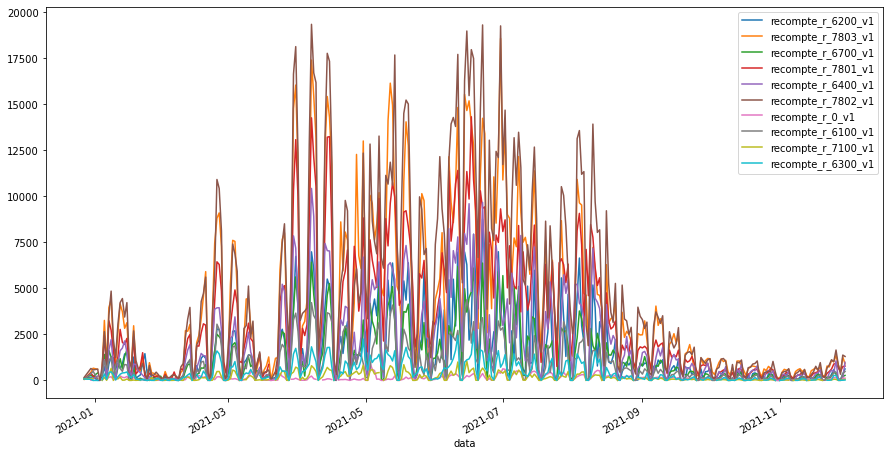

In [12]:
dfVacAll.plot(x="data", figsize=(15,8))

In [13]:
dfVacAll = pd.merge(dfVacAll,dfVac_r_0_v2,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_0_v2'}, inplace = True)
dfVacAll = pd.merge(dfVacAll,dfVac_r_7803_v2,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_7803_v2'}, inplace = True)
dfVacAll = pd.merge(dfVacAll,dfVac_r_6700_v2,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_6700_v2'}, inplace = True)
dfVacAll = pd.merge(dfVacAll,dfVac_r_7801_v2,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_7801_v2'}, inplace = True)
dfVacAll = pd.merge(dfVacAll,dfVac_r_6400_v2,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_6400_v2'}, inplace = True)
dfVacAll = pd.merge(dfVacAll,dfVac_r_7802_v2,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_7802_v2'}, inplace = True)
dfVacAll = pd.merge(dfVacAll,dfVac_r_6200_v2,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_6200_v2'}, inplace = True)
dfVacAll = pd.merge(dfVacAll,dfVac_r_6100_v2,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_6100_v2'}, inplace = True)
dfVacAll = pd.merge(dfVacAll,dfVac_r_7100_v2,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_7100_v2'}, inplace = True)
dfVacAll = pd.merge(dfVacAll,dfVac_r_6300_v2,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_6300_v2'}, inplace = True)

dfVacAll.tail()

,data,recompte_r_6200_v1,recompte_r_7803_v1,recompte_r_6700_v1,recompte_r_7801_v1,recompte_r_6400_v1,recompte_r_7802_v1,recompte_r_0_v1,recompte_r_6100_v1,recompte_r_7100_v1,...,recompte_r_0_v2,recompte_r_7803_v2,recompte_r_6700_v2,recompte_r_7801_v2,recompte_r_6400_v2,recompte_r_7802_v2,recompte_r_6200_v2,recompte_r_6100_v2,recompte_r_7100_v2,recompte_r_6300_v2
327,2021-11-26,362,1361.0,366.0,913.0,1062.0,1652,152.0,454.0,56.0,...,87.0,2954.0,621.0,1291.0,980.0,2303.0,576.0,474.0,77.0,198.0
328,2021-11-27,42,848.0,74.0,679.0,101.0,845,56.0,4.0,3.0,...,33.0,2010.0,25.0,281.0,501.0,726.0,289.0,3.0,2.0,3.0
329,2021-11-28,38,514.0,49.0,487.0,45.0,335,32.0,5.0,1.0,...,8.0,1447.0,21.0,182.0,16.0,301.0,6.0,1.0,3.0,1.0
330,2021-11-29,351,1268.0,214.0,749.0,119.0,1377,120.0,369.0,40.0,...,68.0,2045.0,247.0,1364.0,192.0,1136.0,308.0,167.0,38.0,81.0
331,2021-11-30,623,904.0,271.0,779.0,985.0,1302,124.0,482.0,57.0,...,81.0,1695.0,345.0,1702.0,964.0,1624.0,557.0,353.0,55.0,96.0


In [14]:
#NAN
print(len(dfVacAll.columns))
print(dfVacAll.columns)
print(dfVacAll.isnull().sum(axis=0))
dfVacAll.fillna(0,inplace=True)
#dfVacAll = dfVacAll.iloc[10:]
print(dfVacAll.isnull().sum(axis=0))

21
Index(['data', 'recompte_r_6200_v1', 'recompte_r_7803_v1',
       'recompte_r_6700_v1', 'recompte_r_7801_v1', 'recompte_r_6400_v1',
       'recompte_r_7802_v1', 'recompte_r_0_v1', 'recompte_r_6100_v1',
       'recompte_r_7100_v1', 'recompte_r_6300_v1', 'recompte_r_0_v2',
       'recompte_r_7803_v2', 'recompte_r_6700_v2', 'recompte_r_7801_v2',
       'recompte_r_6400_v2', 'recompte_r_7802_v2', 'recompte_r_6200_v2',
       'recompte_r_6100_v2', 'recompte_r_7100_v2', 'recompte_r_6300_v2'],
      dtype='object')
data                   0
recompte_r_6200_v1     0
recompte_r_7803_v1     1
recompte_r_6700_v1     2
recompte_r_7801_v1     2
recompte_r_6400_v1     1
recompte_r_7802_v1     0
recompte_r_0_v1        8
recompte_r_6100_v1    11
recompte_r_7100_v1    24
recompte_r_6300_v1    16
recompte_r_0_v2       39
recompte_r_7803_v2    23
recompte_r_6700_v2    28
recompte_r_7801_v2    22
recompte_r_6400_v2    29
recompte_r_7802_v2    21
recompte_r_6200_v2    31
recompte_r_6100_v2    36
recompte

In [15]:
# calculate cases by computing the mean of the last 7 days reported cases
cols = dfVacAll.columns
print(cols)
for k in range(1,len(cols)):
    zn = []
    for i in range(dfVacAll.shape[0]):
        acc = 0
        for j in range(7):
            if i-j>=0:
                acc += dfVacAll.iloc[i-j,k]
        zn.append(acc/7)

    dfVacAll[cols[k] + "_7"] = zn
    
dfVacAll = dfVacAll[["data",
       'recompte_r_6200_v1', 'recompte_r_7803_v1',
       'recompte_r_6700_v1', 'recompte_r_7801_v1', 'recompte_r_6400_v1',
       'recompte_r_7802_v1', 'recompte_r_0_v1', 'recompte_r_6100_v1',
       'recompte_r_7100_v1', 'recompte_r_6300_v1', 'recompte_r_6200_v2', 
       'recompte_r_7803_v2',
       'recompte_r_6700_v2', 'recompte_r_7801_v2', 'recompte_r_6400_v2',
       'recompte_r_7802_v2', 'recompte_r_0_v2', 'recompte_r_6100_v2',
       'recompte_r_7100_v2', 'recompte_r_6300_v2',       
       'recompte_r_6200_v1_7', 'recompte_r_7803_v1_7',
       'recompte_r_6700_v1_7', 'recompte_r_7801_v1_7', 'recompte_r_6400_v1_7',
       'recompte_r_7802_v1_7', 'recompte_r_0_v1_7', 'recompte_r_6100_v1_7',
       'recompte_r_7100_v1_7', 'recompte_r_6300_v1_7', 'recompte_r_6200_v2_7', 
       'recompte_r_7803_v2_7',
       'recompte_r_6700_v2_7', 'recompte_r_7801_v2_7', 'recompte_r_6400_v2_7',
       'recompte_r_7802_v2_7', 'recompte_r_0_v2_7', 'recompte_r_6100_v2_7',
       'recompte_r_7100_v2_7', 'recompte_r_6300_v2_7',                  
                    ]]

print(len(dfVacAll.columns))
dfVacAll

Index(['data', 'recompte_r_6200_v1', 'recompte_r_7803_v1',
       'recompte_r_6700_v1', 'recompte_r_7801_v1', 'recompte_r_6400_v1',
       'recompte_r_7802_v1', 'recompte_r_0_v1', 'recompte_r_6100_v1',
       'recompte_r_7100_v1', 'recompte_r_6300_v1', 'recompte_r_0_v2',
       'recompte_r_7803_v2', 'recompte_r_6700_v2', 'recompte_r_7801_v2',
       'recompte_r_6400_v2', 'recompte_r_7802_v2', 'recompte_r_6200_v2',
       'recompte_r_6100_v2', 'recompte_r_7100_v2', 'recompte_r_6300_v2'],
      dtype='object')
41


,data,recompte_r_6200_v1,recompte_r_7803_v1,recompte_r_6700_v1,recompte_r_7801_v1,recompte_r_6400_v1,recompte_r_7802_v1,recompte_r_0_v1,recompte_r_6100_v1,recompte_r_7100_v1,...,recompte_r_6200_v2_7,recompte_r_7803_v2_7,recompte_r_6700_v2_7,recompte_r_7801_v2_7,recompte_r_6400_v2_7,recompte_r_7802_v2_7,recompte_r_0_v2_7,recompte_r_6100_v2_7,recompte_r_7100_v2_7,recompte_r_6300_v2_7
0,2020-12-27,112,58.0,87.0,84.0,76.0,161,0.0,67.0,79.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2020-12-30,172,441.0,295.0,401.0,127.0,648,17.0,363.0,91.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2020-12-31,192,664.0,228.0,232.0,80.0,569,4.0,503.0,113.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2021-01-02,3,603.0,402.0,110.0,233.0,615,0.0,46.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2021-01-03,1,0.0,0.0,0.0,0.0,3,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327,2021-11-26,362,1361.0,366.0,913.0,1062.0,1652,152.0,454.0,56.0,...,402.571429,2331.142857,320.142857,930.428571,430.428571,1188.285714,61.428571,370.714286,48.571429,88.571429
328,2021-11-27,42,848.0,74.0,679.0,101.0,845,56.0,4.0,3.0,...,442.142857,2288.857143,319.285714,943.571429,498.714286,1194.142857,60.857143,370.714286,48.571429,88.571429
329,2021-11-28,38,514.0,49.0,487.0,45.0,335,32.0,5.0,1.0,...,441.857143,2329.285714,319.000000,945.857143,498.571429,1186.857143,60.142857,370.571429,48.714286,88.714286
330,2021-11-29,351,1268.0,214.0,749.0,119.0,1377,120.0,369.0,40.0,...,426.714286,2303.428571,326.000000,1061.571429,514.142857,1257.000000,63.285714,373.285714,49.142857,94.285714


In [16]:
dfVacAll.columns

Index(['data', 'recompte_r_6200_v1', 'recompte_r_7803_v1',
       'recompte_r_6700_v1', 'recompte_r_7801_v1', 'recompte_r_6400_v1',
       'recompte_r_7802_v1', 'recompte_r_0_v1', 'recompte_r_6100_v1',
       'recompte_r_7100_v1', 'recompte_r_6300_v1', 'recompte_r_6200_v2',
       'recompte_r_7803_v2', 'recompte_r_6700_v2', 'recompte_r_7801_v2',
       'recompte_r_6400_v2', 'recompte_r_7802_v2', 'recompte_r_0_v2',
       'recompte_r_6100_v2', 'recompte_r_7100_v2', 'recompte_r_6300_v2',
       'recompte_r_6200_v1_7', 'recompte_r_7803_v1_7', 'recompte_r_6700_v1_7',
       'recompte_r_7801_v1_7', 'recompte_r_6400_v1_7', 'recompte_r_7802_v1_7',
       'recompte_r_0_v1_7', 'recompte_r_6100_v1_7', 'recompte_r_7100_v1_7',
       'recompte_r_6300_v1_7', 'recompte_r_6200_v2_7', 'recompte_r_7803_v2_7',
       'recompte_r_6700_v2_7', 'recompte_r_7801_v2_7', 'recompte_r_6400_v2_7',
       'recompte_r_7802_v2_7', 'recompte_r_0_v2_7', 'recompte_r_6100_v2_7',
       'recompte_r_7100_v2_7', 'recompte_

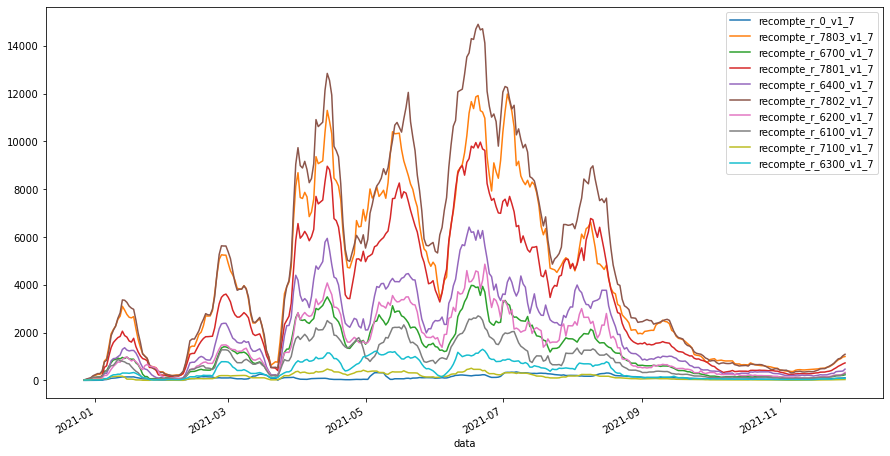

In [17]:
dfVacAll[['data','recompte_r_0_v1_7', 'recompte_r_7803_v1_7', 'recompte_r_6700_v1_7',
       'recompte_r_7801_v1_7', 'recompte_r_6400_v1_7', 'recompte_r_7802_v1_7',
       'recompte_r_6200_v1_7', 'recompte_r_6100_v1_7', 'recompte_r_7100_v1_7',
       'recompte_r_6300_v1_7']].plot(x="data",figsize=(15,8))
plt.show()

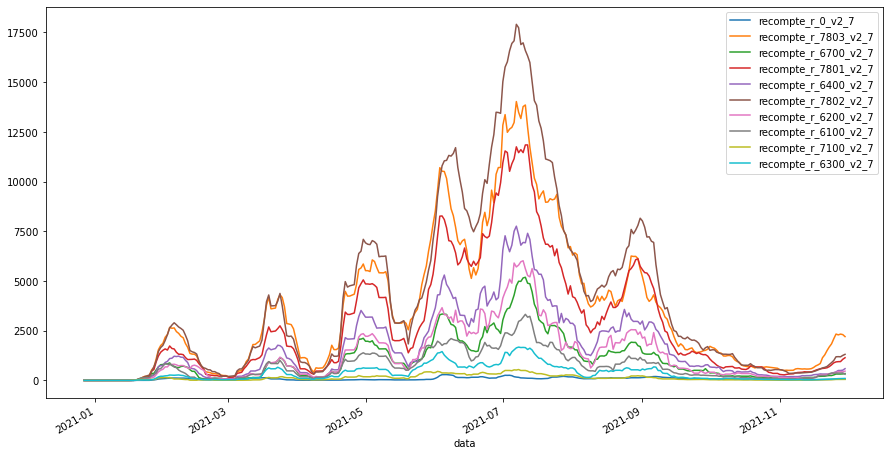

In [18]:
dfVacAll[['data','recompte_r_0_v2_7', 'recompte_r_7803_v2_7', 'recompte_r_6700_v2_7',
       'recompte_r_7801_v2_7', 'recompte_r_6400_v2_7', 'recompte_r_7802_v2_7',
       'recompte_r_6200_v2_7', 'recompte_r_6100_v2_7', 'recompte_r_7100_v2_7',
       'recompte_r_6300_v2_7']].plot(x="data",figsize=(15,8))
plt.show()

In [19]:
#Incidence x regio

In [21]:
dfInc = pd.read_csv("data_flow/CASOS_UCI" + today + ".csv")
dfInc = dfInc[["data","regiosanitariacodi","casos_confirmat"]].groupby(["data","regiosanitariacodi"]).sum().reset_index()
dfInc["numcasos"] = pd.to_numeric(dfInc["casos_confirmat"])
dfInc["data"] = pd.to_datetime(dfInc["data"])
dfInc = dfInc[["data","regiosanitariacodi","numcasos"]]
dfInc.sort_values("data",ascending=True, inplace=True)

In [22]:
# calculate cases by computing the mean of the last 7 days reported cases
dfInc_r_0 = dfInc[dfInc["regiosanitariacodi"]==0][["data","numcasos"]]
dfInc_r_7803 = dfInc[dfInc["regiosanitariacodi"]==7803][["data","numcasos"]]
dfInc_r_6700 = dfInc[dfInc["regiosanitariacodi"]==6700][["data","numcasos"]]
dfInc_r_7801 = dfInc[dfInc["regiosanitariacodi"]==7801][["data","numcasos"]]
dfInc_r_6400 = dfInc[dfInc["regiosanitariacodi"]==6400][["data","numcasos"]]
dfInc_r_7802 = dfInc[dfInc["regiosanitariacodi"]==7802][["data","numcasos"]]
dfInc_r_6200 = dfInc[dfInc["regiosanitariacodi"]==6200][["data","numcasos"]]
dfInc_r_6100 = dfInc[dfInc["regiosanitariacodi"]==6100][["data","numcasos"]]
dfInc_r_7100 = dfInc[dfInc["regiosanitariacodi"]==7100][["data","numcasos"]]
dfInc_r_6300 = dfInc[dfInc["regiosanitariacodi"]==6300][["data","numcasos"]]

print(dfInc_r_0.shape,dfInc_r_7803.shape,dfInc_r_6700.shape,dfInc_r_7801.shape)

if dfInc_r_0.shape[0]==0:
    dfInc = dfInc_r_7803
else:
    dfInc = pd.merge(dfInc_r_0,dfInc_r_7803,how="left", on="data",suffixes=("_r_0","_r_7803"))
    
dfInc = pd.merge(dfInc,dfInc_r_6700,how="left", on="data",suffixes=("_r_7803","_r_6700"))
dfInc = pd.merge(dfInc,dfInc_r_7801,how="left", on="data",suffixes=("_r_6700","_r_7801"))
dfInc = pd.merge(dfInc,dfInc_r_6400,how="left", on="data",suffixes=("_r_7801","_r_6400"))
dfInc = pd.merge(dfInc,dfInc_r_7802,how="left", on="data",suffixes=("_r_6400","_r_7802"))
dfInc = pd.merge(dfInc,dfInc_r_6200,how="left", on="data",suffixes=("_r_7802","_r_6200"))
dfInc = pd.merge(dfInc,dfInc_r_6100,how="left", on="data",suffixes=("_r_6200","_r_6100"))
dfInc = pd.merge(dfInc,dfInc_r_7100,how="left", on="data",suffixes=("_r_6100","_r_7100"))
dfInc = pd.merge(dfInc,dfInc_r_6300,how="left", on="data",suffixes=("_r_7100","_r_6300"))
dfInc['numcasos_r_6300'] = dfInc['numcasos']
dfInc = dfInc[['data', 'numcasos_r_7803', 'numcasos_r_6700', 'numcasos_r_7801',
       'numcasos_r_6400', 'numcasos_r_7802', 'numcasos_r_6200',
       'numcasos_r_6100', 'numcasos_r_7100', 'numcasos_r_6300']]
print(dfInc.columns)
display(dfInc.tail())

(0, 2) (641, 2) (641, 2) (641, 2)
Index(['data', 'numcasos_r_7803', 'numcasos_r_6700', 'numcasos_r_7801',
       'numcasos_r_6400', 'numcasos_r_7802', 'numcasos_r_6200',
       'numcasos_r_6100', 'numcasos_r_7100', 'numcasos_r_6300'],
      dtype='object')


,data,numcasos_r_7803,numcasos_r_6700,numcasos_r_7801,numcasos_r_6400,numcasos_r_7802,numcasos_r_6200,numcasos_r_6100,numcasos_r_7100,numcasos_r_6300
636,2021-11-27,102,48,65,133,248,69,62,10,17
637,2021-11-28,79,45,57,98,159,42,48,3,16
638,2021-11-29,282,130,304,223,399,101,102,23,14
639,2021-11-30,233,104,178,169,379,43,46,9,18
640,2021-12-01,130,66,99,112,160,48,47,11,14


In [23]:
#NAN
print(dfInc.isnull().sum(axis=0))
#dfInc.interpolate(method='polynomial', limit_direction='forward', axis=0, order=2,inplace=True)
#dfInc = dfInc.iloc[10:]
dfInc.fillna(0,inplace=True)
print(dfInc.isnull().sum(axis=0))

data               0
numcasos_r_7803    0
numcasos_r_6700    0
numcasos_r_7801    0
numcasos_r_6400    0
numcasos_r_7802    0
numcasos_r_6200    0
numcasos_r_6100    0
numcasos_r_7100    0
numcasos_r_6300    0
dtype: int64
data               0
numcasos_r_7803    0
numcasos_r_6700    0
numcasos_r_7801    0
numcasos_r_6400    0
numcasos_r_7802    0
numcasos_r_6200    0
numcasos_r_6100    0
numcasos_r_7100    0
numcasos_r_6300    0
dtype: int64


data               0
numcasos_r_7803    0
numcasos_r_6700    0
numcasos_r_7801    0
numcasos_r_6400    0
numcasos_r_7802    0
numcasos_r_6200    0
numcasos_r_6100    0
numcasos_r_7100    0
numcasos_r_6300    0
dtype: int64
Index(['data', 'numcasos_r_7803', 'numcasos_r_6700', 'numcasos_r_7801',
       'numcasos_r_6400', 'numcasos_r_7802', 'numcasos_r_6200',
       'numcasos_r_6100', 'numcasos_r_7100', 'numcasos_r_6300'],
      dtype='object')


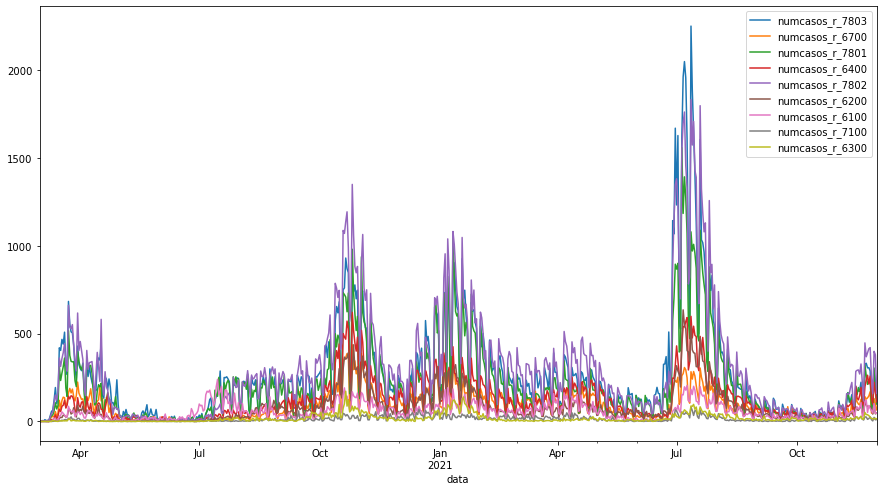

In [24]:
dfInc.plot(x="data",figsize=(15,8))
print(dfInc.isnull().sum(axis=0))
print(dfInc.columns)
plt.show()

In [26]:
# calculate cases by computing the mean of the last 7 days reported cases
cols = dfInc.columns
print(cols)
for k in range(1,len(cols)):
    zn = []
    for i in range(dfInc.shape[0]):
        acc = 0
        for j in range(7):
            if i-j>=0:
                acc += dfInc.iloc[i-j,k]
        zn.append(acc/7)

    dfInc[cols[k] + "_7"] = zn
    
dfInc = dfInc[["data",
       'numcasos_r_7803', 'numcasos_r_6700',
       'numcasos_r_7801', 'numcasos_r_6400', 'numcasos_r_7802',
       'numcasos_r_6200', 'numcasos_r_6100', 'numcasos_r_7100',
       'numcasos_r_6300',            
       'numcasos_r_7803_7', 'numcasos_r_6700_7',
       'numcasos_r_7801_7', 'numcasos_r_6400_7', 'numcasos_r_7802_7',
       'numcasos_r_6200_7', 'numcasos_r_6100_7', 'numcasos_r_7100_7',
       'numcasos_r_6300_7']]
dfInc

Index(['data', 'numcasos_r_7803', 'numcasos_r_6700', 'numcasos_r_7801',
       'numcasos_r_6400', 'numcasos_r_7802', 'numcasos_r_6200',
       'numcasos_r_6100', 'numcasos_r_7100', 'numcasos_r_6300',
       'numcasos_r_7803_7', 'numcasos_r_6700_7', 'numcasos_r_7801_7',
       'numcasos_r_6400_7', 'numcasos_r_7802_7', 'numcasos_r_6200_7',
       'numcasos_r_6100_7', 'numcasos_r_7100_7', 'numcasos_r_6300_7'],
      dtype='object')


,data,numcasos_r_7803,numcasos_r_6700,numcasos_r_7801,numcasos_r_6400,numcasos_r_7802,numcasos_r_6200,numcasos_r_6100,numcasos_r_7100,numcasos_r_6300,numcasos_r_7803_7,numcasos_r_6700_7,numcasos_r_7801_7,numcasos_r_6400_7,numcasos_r_7802_7,numcasos_r_6200_7,numcasos_r_6100_7,numcasos_r_7100_7,numcasos_r_6300_7
0,2020-03-01,4,0,0,1,2,0,0,0,0,0.571429,0.000000,0.000000,0.142857,0.285714,0.000000,0.000000,0.000000,0.000000
1,2020-03-02,2,1,1,0,0,0,0,0,0,0.857143,0.142857,0.142857,0.142857,0.285714,0.000000,0.000000,0.000000,0.000000
2,2020-03-03,5,1,3,1,2,0,0,0,0,1.571429,0.285714,0.571429,0.285714,0.571429,0.000000,0.000000,0.000000,0.000000
3,2020-03-04,3,1,1,1,1,0,0,0,0,2.000000,0.428571,0.714286,0.428571,0.714286,0.000000,0.000000,0.000000,0.000000
4,2020-03-05,10,2,2,2,3,0,0,0,0,3.428571,0.714286,1.000000,0.714286,1.142857,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636,2021-11-27,102,48,65,133,248,69,62,10,17,244.000000,114.571429,199.714286,198.142857,343.571429,81.857143,79.285714,17.571429,30.714286
637,2021-11-28,79,45,57,98,159,42,48,3,16,248.285714,115.571429,198.714286,199.714286,349.714286,82.142857,80.000000,16.857143,31.142857
638,2021-11-29,282,130,304,223,399,101,102,23,14,241.857143,114.000000,196.285714,203.142857,342.857143,80.285714,78.285714,16.428571,25.857143
639,2021-11-30,233,104,178,169,379,43,46,9,18,227.857143,110.714286,184.571429,193.857143,344.428571,73.142857,67.571429,14.142857,22.857143


data                 0
numcasos_r_7803      0
numcasos_r_6700      0
numcasos_r_7801      0
numcasos_r_6400      0
numcasos_r_7802      0
numcasos_r_6200      0
numcasos_r_6100      0
numcasos_r_7100      0
numcasos_r_6300      0
numcasos_r_7803_7    0
numcasos_r_6700_7    0
numcasos_r_7801_7    0
numcasos_r_6400_7    0
numcasos_r_7802_7    0
numcasos_r_6200_7    0
numcasos_r_6100_7    0
numcasos_r_7100_7    0
numcasos_r_6300_7    0
dtype: int64
Index(['data', 'numcasos_r_7803', 'numcasos_r_6700', 'numcasos_r_7801',
       'numcasos_r_6400', 'numcasos_r_7802', 'numcasos_r_6200',
       'numcasos_r_6100', 'numcasos_r_7100', 'numcasos_r_6300',
       'numcasos_r_7803_7', 'numcasos_r_6700_7', 'numcasos_r_7801_7',
       'numcasos_r_6400_7', 'numcasos_r_7802_7', 'numcasos_r_6200_7',
       'numcasos_r_6100_7', 'numcasos_r_7100_7', 'numcasos_r_6300_7'],
      dtype='object')


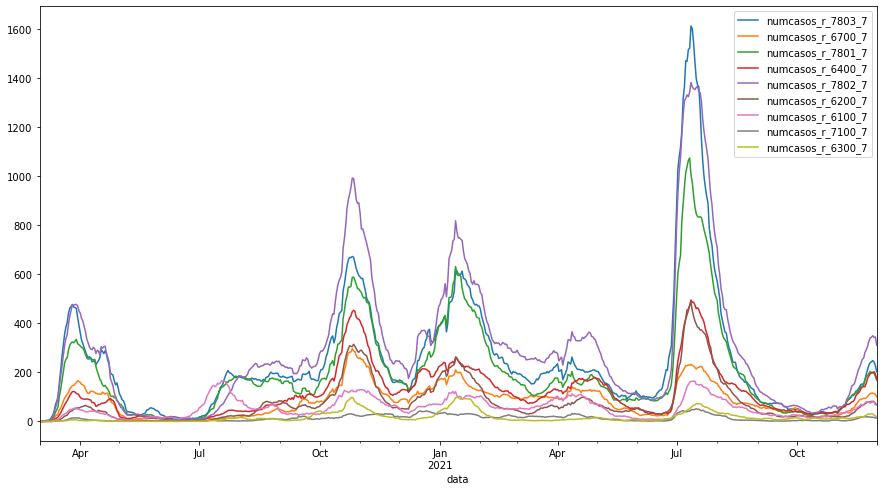

In [27]:
dfInc[['data','numcasos_r_7803_7', 'numcasos_r_6700_7',
       'numcasos_r_7801_7', 'numcasos_r_6400_7', 'numcasos_r_7802_7',
       'numcasos_r_6200_7', 'numcasos_r_6100_7', 'numcasos_r_7100_7',
       'numcasos_r_6300_7']].plot(x="data",figsize=(15,8))
print(dfInc.isnull().sum(axis=0))
print(dfInc.columns)
plt.show()

In [28]:
#Merge (BCN CENTRE)

In [29]:
print(dfInc.columns)
print(dfVacAll.columns)

Index(['data', 'numcasos_r_7803', 'numcasos_r_6700', 'numcasos_r_7801',
       'numcasos_r_6400', 'numcasos_r_7802', 'numcasos_r_6200',
       'numcasos_r_6100', 'numcasos_r_7100', 'numcasos_r_6300',
       'numcasos_r_7803_7', 'numcasos_r_6700_7', 'numcasos_r_7801_7',
       'numcasos_r_6400_7', 'numcasos_r_7802_7', 'numcasos_r_6200_7',
       'numcasos_r_6100_7', 'numcasos_r_7100_7', 'numcasos_r_6300_7'],
      dtype='object')
Index(['data', 'recompte_r_6200_v1', 'recompte_r_7803_v1',
       'recompte_r_6700_v1', 'recompte_r_7801_v1', 'recompte_r_6400_v1',
       'recompte_r_7802_v1', 'recompte_r_0_v1', 'recompte_r_6100_v1',
       'recompte_r_7100_v1', 'recompte_r_6300_v1', 'recompte_r_6200_v2',
       'recompte_r_7803_v2', 'recompte_r_6700_v2', 'recompte_r_7801_v2',
       'recompte_r_6400_v2', 'recompte_r_7802_v2', 'recompte_r_0_v2',
       'recompte_r_6100_v2', 'recompte_r_7100_v2', 'recompte_r_6300_v2',
       'recompte_r_6200_v1_7', 'recompte_r_7803_v1_7', 'recompte_r_6700_v1_7

In [30]:
from pickle import dump

In [39]:
selCodisReg = ['6100', '6200', '6300', '6400', '6700', '7100', '7801', '7802','7803']

In [40]:
fnamePrefix = "best_model_region_vacc.02122021.deep"

In [ ]:
all_history = []
all_min_tr = []
all_min_val = []

for cod in selCodisReg:
    
    print("\nNEW REGION:", cod)
    
    #Merge data
    start = time.time()
    dfAll = pd.merge(dfInc[["data",'numcasos_r_'+cod,'numcasos_r_'+cod+'_7']],
                     dfVacAll[["data","recompte_r_"+cod+"_v1","recompte_r_"+cod+"_v2",
                               "recompte_r_"+cod+"_v1_7","recompte_r_"+cod+"_v2_7"]], 
                     how="left",on="data",suffixes=("","")
                    )
    dfAll.fillna(0,inplace=True)
    
    #Remove last day 
    dfAll = dfAll.iloc[:-3]    
    
    #Convert data to format (rows,timepoints,features)
    cols = [
           'numcasos_r_'+cod, #'numcasos_r_7803_7', 
           'recompte_r_'+cod+'_v1','recompte_r_'+cod+'_v2', 
           #'recompte_r_7803_v1_7', 'recompte_r_7803_v2_7'
    ]
    ncols=len(cols)
    res = series_to_supervised(dfAll.loc[:,cols].values,21,21)
    THR = res.shape[0]-21    
    
    #Patition train/test
    train_X = res.iloc[:THR,:(21*ncols)].values.reshape(-1,21,ncols)
    train_y = res.iloc[:THR,[(21*ncols)+(ncols*i) for i in range(21)]].values.reshape(-1,21)
    test_X = res.iloc[THR:,:(21*ncols)].values.reshape(-1,21,ncols)
    test_y = res.iloc[THR:,[(21*ncols)+(ncols*i) for i in range(21)]].values.reshape(-1,21)   
    fname = fnamePrefix+cod
    
    # normalize features
    scalers_X = []
    for i in range(train_X.shape[-1]):

        # normalize features
        scaler = MinMaxScaler(feature_range=(0, 1))
        train_X[:,:,i] = scaler.fit_transform(train_X[:,:,i])
        test_X[:,:,i] = scaler.transform(test_X[:,:,i])
        scalers_X.append(scaler)
        dump(scaler, open("models/"+ fname + "_scaler_tr_X_" + str(i)+'.pkl', 'wb'))

    scaler_y = MinMaxScaler(feature_range=(0, 1))
    train_y = scaler_y.fit_transform(train_y.reshape(-1,21))
    test_y = scaler_y.transform(test_y.reshape(-1,21))
    dump(scaler_y, open("models/"+ fname + "_scaler_tr_Y.pkl", 'wb'))    
    

    # fit network
    bs=4
    history=[]
    min_tr = []
    min_val = []
    for i in range(5):
        model = keras.Sequential()
        model.add(keras.layers.LSTM(50, activation="relu",
                                    input_shape=(train_X.shape[1], train_X.shape[2]),recurrent_dropout=0.3,
                                    return_sequences=True))
        model.add(keras.layers.Dropout(0.3))
        model.add(keras.layers.LSTM(50,recurrent_dropout=0.3))
        model.add(keras.layers.Dropout(0.3))
        model.add(keras.layers.Dense(21))
        opt = keras.optimizers.Adam(learning_rate=0.001) 
        model.compile(loss='mean_squared_error', optimizer=opt,metrics=["mae","mse"])

        # design callbacks
        es = keras.callbacks.EarlyStopping(monitor='val_mae', 
                                           verbose=1, patience=50) 
        reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_mae', factor=0.2, 
                                                      patience=30,verbose=1)
        mc = keras.callbacks.ModelCheckpoint("models/"+ fname + "_" + str(i) +'.h5', 
                                             monitor='val_mae', 
                                             verbose=1, save_best_only=True)

        history.append(model.fit(train_X, train_y, epochs=500, batch_size=bs, 
                            callbacks=[es,mc,reduce_lr],
                            validation_split=0.10, verbose=0, shuffle=False)) #20

        ix = np.argmin(history[-1].history.get('val_mae'))
        min_val.append(history[-1].history.get('val_mae')[ix])
        min_tr.append(history[-1].history.get('mae')[ix])

        
    print("\nMIN TR:",np.mean(min_tr),np.std(min_tr))
    print("MIN VAL:",np.mean(min_val),np.std(min_val))
    print("DURATION:", (time.time()-start)/60.)
    
    all_history.append(history)
    all_min_tr.append(min_tr)
    all_min_val.append(min_val)


NEW REGION: 6100

Epoch 00001: val_mae improved from inf to 0.11158, saving model to models/best_model_region_vacc.02122021.deep6100_0.h5

Epoch 00002: val_mae improved from 0.11158 to 0.10928, saving model to models/best_model_region_vacc.02122021.deep6100_0.h5

Epoch 00003: val_mae did not improve from 0.10928

Epoch 00004: val_mae did not improve from 0.10928

Epoch 00005: val_mae did not improve from 0.10928

Epoch 00006: val_mae did not improve from 0.10928

Epoch 00007: val_mae improved from 0.10928 to 0.10063, saving model to models/best_model_region_vacc.02122021.deep6100_0.h5

Epoch 00008: val_mae did not improve from 0.10063

Epoch 00009: val_mae improved from 0.10063 to 0.09122, saving model to models/best_model_region_vacc.02122021.deep6100_0.h5

Epoch 00010: val_mae did not improve from 0.09122

Epoch 00011: val_mae did not improve from 0.09122

Epoch 00012: val_mae did not improve from 0.09122

Epoch 00013: val_mae improved from 0.09122 to 0.08765, saving model to models


Epoch 00133: val_mae did not improve from 0.05492

Epoch 00134: val_mae did not improve from 0.05492

Epoch 00135: val_mae did not improve from 0.05492

Epoch 00136: val_mae did not improve from 0.05492

Epoch 00137: val_mae did not improve from 0.05492

Epoch 00138: val_mae did not improve from 0.05492

Epoch 00139: val_mae did not improve from 0.05492

Epoch 00139: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 00140: val_mae did not improve from 0.05492

Epoch 00141: val_mae did not improve from 0.05492

Epoch 00142: val_mae did not improve from 0.05492

Epoch 00143: val_mae did not improve from 0.05492

Epoch 00144: val_mae did not improve from 0.05492

Epoch 00145: val_mae did not improve from 0.05492

Epoch 00146: val_mae did not improve from 0.05492

Epoch 00147: val_mae did not improve from 0.05492

Epoch 00148: val_mae did not improve from 0.05492

Epoch 00149: val_mae did not improve from 0.05492

Epoch 00150: val_mae did not improve from 0.05492



Epoch 00032: val_mae did not improve from 0.06426

Epoch 00033: val_mae did not improve from 0.06426

Epoch 00034: val_mae did not improve from 0.06426

Epoch 00035: val_mae did not improve from 0.06426

Epoch 00036: val_mae did not improve from 0.06426

Epoch 00037: val_mae did not improve from 0.06426

Epoch 00038: val_mae did not improve from 0.06426

Epoch 00039: val_mae did not improve from 0.06426

Epoch 00040: val_mae did not improve from 0.06426

Epoch 00041: val_mae did not improve from 0.06426

Epoch 00042: val_mae did not improve from 0.06426

Epoch 00043: val_mae did not improve from 0.06426

Epoch 00044: val_mae did not improve from 0.06426

Epoch 00045: val_mae did not improve from 0.06426

Epoch 00046: val_mae did not improve from 0.06426

Epoch 00047: val_mae did not improve from 0.06426

Epoch 00048: val_mae did not improve from 0.06426

Epoch 00049: val_mae did not improve from 0.06426

Epoch 00050: val_mae did not improve from 0.06426

Epoch 00051: val_mae did not i

In [ ]:
#TEST

In [147]:
for i in range(len(all_history)):
    print("\n" + str(i)+" "+str(selCodisReg[i]))
    print("TR: "+ str(np.mean(all_min_tr[i]))+" VAL: "+str(np.mean(all_min_val[i]))+"+/-"+str(np.std(all_min_val[i])))
    print("TR: "+ str(all_min_tr[i]))
    print("VAL: "+ str(all_min_val[i]))



0 0
TR: 0.14124587 VAL: 0.07598734+/-0.0050831437
TR: [0.13588615, 0.13973866, 0.13051376, 0.13620657, 0.16388424]
VAL: [0.07385424, 0.068996154, 0.08465865, 0.07572871, 0.076698944]

1 6100
TR: 0.12492029 VAL: 0.09554368+/-0.0024744978
TR: [0.1173899, 0.11607653, 0.1337453, 0.115375675, 0.14201407]
VAL: [0.0937531, 0.09416587, 0.099407725, 0.09292228, 0.09746944]

2 6200
TR: 0.1549495 VAL: 0.056827903+/-0.0032907464
TR: [0.1463541, 0.15680958, 0.15502709, 0.16103162, 0.1555251]
VAL: [0.05705074, 0.058538437, 0.061792366, 0.052209906, 0.05454806]

3 6300
TR: 0.14778154 VAL: 0.044790454+/-0.0012171076
TR: [0.15032475, 0.14537679, 0.14415601, 0.14808173, 0.15096842]
VAL: [0.044859543, 0.0452085, 0.04411918, 0.043044098, 0.04672096]

4 6400
TR: 0.13446257 VAL: 0.07495334+/-0.0014854381
TR: [0.13318266, 0.13431178, 0.13830039, 0.13219467, 0.13432328]
VAL: [0.07380159, 0.07691614, 0.07609449, 0.07282708, 0.075127386]

5 6700
TR: 0.14666837 VAL: 0.10178609+/-0.0032592951
TR: [0.15070966, 0.

dict_keys(['loss', 'mean_absolute_error', 'mean_squared_error', 'val_loss', 'val_mean_absolute_error', 'val_mean_squared_error'])
MAE VALSET: 0 0.0937531
MAE VALSET: 1 0.09416587
MAE VALSET: 2 0.099407725
MAE VALSET: 3 0.09292228
MAE VALSET: 4 0.09746944
MAE VALSE (MEAN): 0.09554368


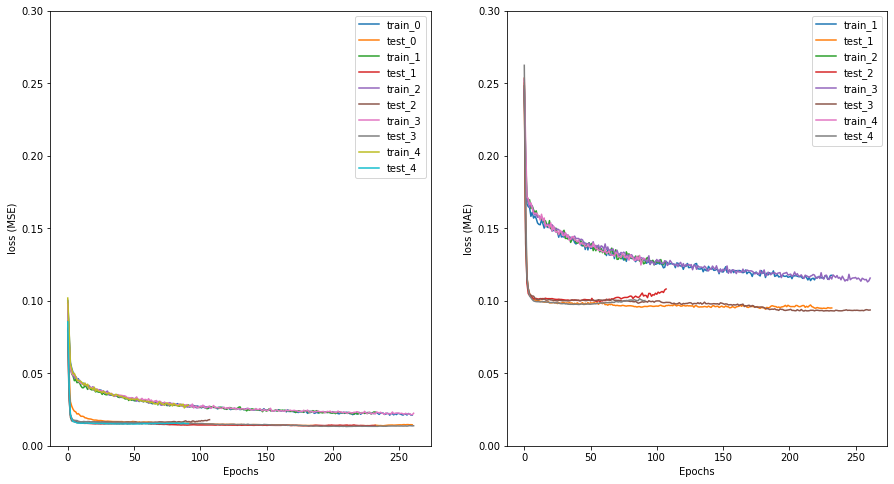

In [149]:
#Plot learning
for hist in range(1,len(all_history)):

    history = all_history[hist]
    plt.figure(figsize=(15,8))
    ax = plt.subplot(1,2,1)

    print(history[0].history.keys())

    mins = []
    for i in range(len(history)):
        mins.append(np.min(history[i].history.get('val_mean_absolute_error')))
        print("MAE VALSET:", i,np.min(history[i].history.get('val_mean_absolute_error')))
        ax.plot(history[i].history['loss'], label='train_'+str(i))
        ax.plot(history[i].history['val_loss'], label='test_'+str(i))
        ax.legend()
    ax.set_ylim(0,0.3)
    ax.set_ylabel("loss (MSE)")
    ax.set_xlabel("Epochs")
    print("MAE VALSE (MEAN):", np.mean(mins))

    ax = plt.subplot(1,2,2)
    for i in range(1,len(history)):
        ax.plot(history[i].history['mean_absolute_error'], label='train_'+str(i))
        ax.plot(history[i].history['val_mean_absolute_error'], label='test_'+str(i))
        ax.legend()
    ax.set_ylim(0,0.3)
    ax.set_ylabel("loss (MAE)")
    ax.set_xlabel("Epochs")
    plt.show()
    break

#0.0605

In [ ]:
#Error

In [19]:
from pickle import load
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [44]:
for cod in ["7100"]:#selCodisReg[1:]:
    
    print(cod)
    fname = "best_model_region_vacc.28052021."+cod  

    #Read data
    dfAll = pd.merge(dfInc[["data",'numcasos_r_'+cod,'numcasos_r_'+cod+'_7']],
                     dfVacAll[["data","recompte_r_"+cod+"_v1","recompte_r_"+cod+"_v2",
                               "recompte_r_"+cod+"_v1_7","recompte_r_"+cod+"_v2_7"]], 
                     how="left",on="data",suffixes=("","")
                    )
    print(np.sum(dfAll.isnull(), axis=0))
    dfAll.fillna(0,inplace=True)

    #Remove last day 
    dfAll = dfAll.iloc[:-3]    
    print(dfAll.columns)

    #Convert data to format (rows,timepoints,features)
    cols = [
           'numcasos_r_'+cod, #'numcasos_r_7803_7', 
           'recompte_r_'+cod+'_v1','recompte_r_'+cod+'_v2', 
           #'recompte_r_7803_v1_7', 'recompte_r_7803_v2_7'
    ]
    ncols=len(cols)
    res = series_to_supervised(dfAll.loc[:,cols].values,21,21)
    THR = res.shape[0]-21    

    #Patition train/test
    train_X = res.iloc[:THR,:(21*ncols)].values.reshape(-1,21,ncols)
    train_y = res.iloc[:THR,[(21*ncols)+(ncols*i) for i in range(21)]].values.reshape(-1,21)
    test_X = res.iloc[THR:,:(21*ncols)].values.reshape(-1,21,ncols)
    test_y = res.iloc[THR:,[(21*ncols)+(ncols*i) for i in range(21)]].values.reshape(-1,21)   


    # normalize features
    scalers_X = []
    for i in range(train_X.shape[-1]):

        # normalize features
        scaler = load(open("models/"+ fname + "_scaler_tr_X_" + str(i)+'.pkl', 'rb'))
        train_X[:,:,i] = scaler.transform(train_X[:,:,i])
        test_X[:,:,i] = scaler.transform(test_X[:,:,i])

    scaler_y = load(open("models/"+ fname + "_scaler_tr_Y.pkl", 'rb'))
    train_y = scaler_y.transform(train_y.reshape(-1,21))
    test_y = scaler_y.transform(test_y.reshape(-1,21))

    #Evaluate
    err_mse_all = []
    err_mae_all = []
    err_perc_all = []
    err_acc_all = []
    for cc in range(5):

        err_mse = []
        err_mae = []
        err_perc = []
        err_acc = []
        
        print("Loading...", "models/"+ fname + "_" + str(cc) +'.h5')
        model = tf.keras.models.load_model("models/"+ fname + "_" + str(cc) +'.h5')
        tr = model.predict(train_X)
        ts = model.predict(test_X)
        
        tr_y_pred = scaler_y.inverse_transform(tr)
        tr_y_real = scaler_y.inverse_transform(train_y)        
        ts_y_pred = scaler_y.inverse_transform(ts)
        ts_y_real = scaler_y.inverse_transform(test_y)    

        for i in [1,3,7,14,21]:

            mse = []
            mae = []
            perc = []
            for k in range(len(ts_y_real)):
                mse.append(mean_squared_error(ts_y_real[k,:i],ts_y_pred[k,:i]))
                mae.append(mean_absolute_error(ts_y_real[k,:i],ts_y_pred[k,:i]))
                res = mean_absolute_percentage_error(ts_y_real[k,:i],ts_y_pred[k,:i])
                if res > 10:
                    res = np.mean(perc)
                perc.append(res)
                
            err_mse.append(np.mean(mse))
            err_mae.append(np.mean(mae))
            err_perc.append(np.mean(perc))
            
        
        
        err_mse_all.append(err_mse)
        err_mae_all.append(err_mae)
        err_perc_all.append(err_perc)

    #Results
    total_rmse = []
    total_mae = []
    total_mape = []
    total_err = []
    for cc in range(5):
        t_rmse = []
        t_mae = []
        t_mape = []
        t_errDif = []
        for k,i in enumerate([1,3,7,14,21]):
            t_rmse.append(np.array(err_mse_all)[cc,k])
            t_mae.append(np.array(err_mae_all)[cc,k])
            t_mape.append(np.array(err_perc_all)[cc,k])
        total_rmse.append(t_rmse)
        total_mae.append(t_mae)
        total_mape.append(t_mape)

    total_rmse1 = np.array(total_rmse).reshape(5,5)
    total_mae1 = np.array(total_mae).reshape(5,5)
    total_mape1 = np.array(total_mape).reshape(5,5)

    print("RMSE (daily):")
    print(np.mean(total_rmse1,axis=0).round(3), np.std(total_rmse1,axis=0).round(3))
    print("MAE (daily):")
    print(np.mean(total_mae1,axis=0).round(3),np.std(total_mae1,axis=0).round(3))
    print("MAPE (daily):")
    print(np.mean(total_mape1,axis=0).round(3), np.std(total_mape1,axis=0).round(3))

    res = []
    for i,k in enumerate([1,3,7,14,21]):
        res.append([
            k,
            str(np.mean(total_mape1,axis=0).round(3)[i]) + "+/-" +  str(np.std(total_mape1,axis=0).round(3)[i]),
            str(np.mean(total_mae1,axis=0).round(3)[i]) + "+/-" + str(np.std(total_mae1,axis=0).round(3)[i]),
            str(np.mean(total_rmse1,axis=0).round(3)[i]) + "+/-" + str(np.std(total_rmse1,axis=0).round(3)[i]),
                   ])
    dfRes = pd.DataFrame(res,columns=["Day","MAPE","MAE","MSE"])
    dfRes.reset_index(drop=True,inplace=True)
    display(dfRes)


7100
data                      0
numcasos_r_7100           0
numcasos_r_7100_7         0
recompte_r_7100_v1      291
recompte_r_7100_v2      291
recompte_r_7100_v1_7    291
recompte_r_7100_v2_7    291
dtype: int64
Index(['data', 'numcasos_r_7100', 'numcasos_r_7100_7', 'recompte_r_7100_v1',
       'recompte_r_7100_v2', 'recompte_r_7100_v1_7', 'recompte_r_7100_v2_7'],
      dtype='object')
Loading... models/best_model_region_vacc.28052021.7100_0.h5


/homedtic/jrafael/anaconda3/envs/deeplung/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/homedtic/jrafael/anaconda3/envs/deeplung/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/homedtic/jrafael/anaconda3/envs/deeplung/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/homedtic/jrafael/anaconda3/envs/deeplung/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator MinMaxScaler from 

Loading... models/best_model_region_vacc.28052021.7100_1.h5
Loading... models/best_model_region_vacc.28052021.7100_2.h5
Loading... models/best_model_region_vacc.28052021.7100_3.h5
Loading... models/best_model_region_vacc.28052021.7100_4.h5
RMSE (daily):
[190.853 172.572 149.378 154.955 180.889] [23.343  7.924 19.977 27.121 33.603]
MAE (daily):
[10.974 10.75  10.104 10.443 11.531] [0.503 0.465 0.999 1.185 1.374]
MAPE (daily):
[0.862 0.984 1.046 1.396 2.032] [0.143 0.16  0.183 0.228 0.282]


,Day,MAPE,MAE,MSE
0,1,0.862+/-0.143,10.974+/-0.503,190.853+/-23.343
1,3,0.984+/-0.16,10.75+/-0.465,172.572+/-7.924
2,7,1.046+/-0.183,10.104+/-0.999,149.378+/-19.977
3,14,1.396+/-0.228,10.443+/-1.185,154.955+/-27.121
4,21,2.032+/-0.282,11.531+/-1.374,180.889+/-33.603


In [46]:
#Forecasting future!!

In [75]:
res_test = series_to_supervised(dfAll.loc[:,cols].values,21,21,dropnan=False)
print(cols)
res_test.shape

['new_cases', 'new_cases_7', 'new_cases_GI_7', 'new_cases_TAR_7', 'new_cases_BCN_7', 'new_cases_LLE_7']


(395, 252)

In [77]:
#Find rows for future pred
ftest_X = res_test.iloc[-1,:(21*ncols)].values.reshape(-1,21,ncols)
ftest_y = res_test.iloc[-1,[(21*ncols)+(ncols*i) for i in range(21)]].values.reshape(-1,21)
print(ftest_X.shape, ftest_y.shape)
print("X test:")
display(ftest_X[0,:,0])
print("Y test:")
print(ftest_y[0,:])

(1, 21, 6) (1, 21)
X test:


array([1440., 1243., 1117., 1127.,  794.,  690., 1355., 1217., 1112.,
        906., 1052.,  735.,  650., 1144., 1046., 1070., 1013., 1069.,
        822.,  708., 1298.])

Y test:
[1270.   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
   nan   nan   nan   nan   nan   nan   nan   nan   nan]


In [78]:
from pickle import load

# normalize features
for i in range(ftest_X.shape[-1]):

    # normalize features
    scalers_X = load(open("models/"+ fname + "_scaler_tr_X_" + str(i)+'.pkl', 'rb'))

    ftest_X[:,:,i] = scalers_X.transform(ftest_X[:,:,i])
    print(i, ftest_X[:,:,i].max(), ftest_X[:,:,i].min())

print(ftest_X.shape)
print(np.nanmax(ftest_X),np.nanmin(ftest_X),np.nanmean(ftest_X),np.nanstd(ftest_X))

0 0.2587664089192591 0.11351741562894785
1 0.2706685186303521 0.19117240531990048
2 0.22814172826918175 0.14839537869062902
3 0.1099890829694323 0.06581103222282907
4 0.28889809444904724 0.2022778851811381
5 0.4235941320293398 0.3471882640586797
(1, 21, 6)
0.4235941320293398 0.06581103222282907 0.21335701780089822 0.09390686264250053


In [79]:
#Forecasting last X days for all models

In [80]:
all_preds = []
for i in range(10):
    print("\nLoading model:", i)
    model = tf.keras.models.load_model("models/"+ fname + "_" + str(i) +'.h5')
    preds = model.predict(ftest_X)
    scaler_y = load(open("models/"+ fname + "_scaler_tr_Y.pkl", 'rb'))

    preds_inv = scaler_y.inverse_transform(preds)
    print(len(preds_inv), np.max(preds_inv), np.min(preds_inv))
    print(preds_inv.shape)
    all_preds.append(preds_inv)


Loading model: 0
1 1435.4344 1028.0311
(1, 21)

Loading model: 1
1 1376.1207 934.2348
(1, 21)

Loading model: 2
1 1473.0641 1059.0972
(1, 21)

Loading model: 3
1 1293.2899 888.31494
(1, 21)

Loading model: 4
1 1030.4153 845.21405
(1, 21)

Loading model: 5
1 1590.7592 921.99133
(1, 21)

Loading model: 6
1 939.076 663.57935
(1, 21)

Loading model: 7
1 1035.0734 869.0903
(1, 21)

Loading model: 8
1 1183.8429 857.0101
(1, 21)

Loading model: 9
1 1244.6375 947.19806
(1, 21)


In [81]:
all_preds_aux = np.stack((all_preds))
print(all_preds_aux.shape)

all_preds_aux[:,-1,:].mean(axis=0)
all_preds_aux[:,-1,:].std(axis=0)

(10, 1, 21)


array([ 56.439705,  57.557087,  62.39034 ,  60.032993,  87.6961  ,
        90.16416 , 103.349106, 111.41926 , 122.06503 , 132.49138 ,
       138.87975 , 152.23672 , 175.90685 , 171.30928 , 193.5738  ,
       200.0936  , 208.23343 , 215.73346 , 232.63503 , 230.8465  ,
       243.24458 ], dtype=float32)

In [82]:
all_res = all_preds_aux[:,:all_preds_aux.shape[1]]
for i in range(all_preds_aux.shape[1]-1,19,-1):
    all_res = np.hstack((all_preds_aux[:,i,-1].reshape(10,1),all_res))
    #print(all_res.shape)

all_res = np.array(all_res)
print(all_res.shape)

(10, 1, 21)


In [83]:
dfPreds = pd.DataFrame(np.hstack((all_res)).astype(int).reshape(10,21),
                       columns=["d"+str(i) for i in range(21)])
dfPreds.astype(int).to_csv("preds_infected_21days" + today + ".csv",index=False)
dfPreds.describe().T

,count,mean,std,min,25%,50%,75%,max
d0,10.0,965.1,59.623728,901.0,921.75,944.0,1009.00,1081.0
d1,10.0,973.4,60.760367,909.0,922.50,971.5,1000.50,1099.0
d2,10.0,985.2,65.631632,888.0,930.25,993.0,1029.75,1096.0
d3,10.0,967.8,63.289107,890.0,920.25,952.0,1012.75,1063.0
d4,10.0,966.0,92.398894,853.0,887.25,959.0,1013.00,1121.0
d5,10.0,955.6,95.039407,845.0,890.25,924.0,1025.25,1101.0
d6,10.0,962.1,108.736634,853.0,872.25,921.0,1062.00,1135.0
d7,10.0,960.9,117.329972,818.0,881.50,929.5,1027.75,1150.0
d8,10.0,992.6,128.699650,777.0,902.25,1000.5,1042.25,1196.0
d9,10.0,985.2,139.523634,746.0,889.75,990.5,1112.75,1160.0


In [84]:
import datetime
import matplotlib.dates as mdates
date_time_str = '2021-03-19' #Last data collected day
base = datetime.datetime.strptime(date_time_str, '%Y-%m-%d')
date_list = [(base + datetime.timedelta(days=x)).strftime('%Y-%m-%d') for x in range(21)]
print(date_list)

['2021-03-19', '2021-03-20', '2021-03-21', '2021-03-22', '2021-03-23', '2021-03-24', '2021-03-25', '2021-03-26', '2021-03-27', '2021-03-28', '2021-03-29', '2021-03-30', '2021-03-31', '2021-04-01', '2021-04-02', '2021-04-03', '2021-04-04', '2021-04-05', '2021-04-06', '2021-04-07', '2021-04-08']


In [85]:
dfPredsT = dfPreds.T
dfPredsT.reset_index(drop=True, inplace=True)
dfPredsT["date"] = date_list
dfPredsT.head()

,0,1,2,3,4,5,6,7,8,9,date
0,1028,964,1081,901,910,946,939,916,942,1024,2021-03-19
1,1031,1005,1099,967,910,976,930,909,920,987,2021-03-20
2,1048,1000,1096,986,946,1008,925,918,888,1037,2021-03-21
3,1063,997,1059,937,967,921,920,890,906,1018,2021-03-22
4,1094,962,1121,956,879,1019,853,869,912,995,2021-03-23


In [86]:
print(dfPredsT[[i for i in range(10)]].mean(axis=1).mean(axis=0))
print(dfPredsT[[i for i in range(10)]].mean(axis=1).std(axis=0))
print(np.mean(dfPredsT[[i for i in range(10)]].values),
      np.std(dfPredsT[[i for i in range(10)]].values))

1037.4333333333334
85.5941080526769
1037.4333333333334 178.45065433263625


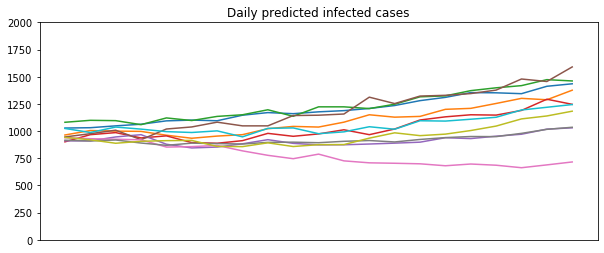

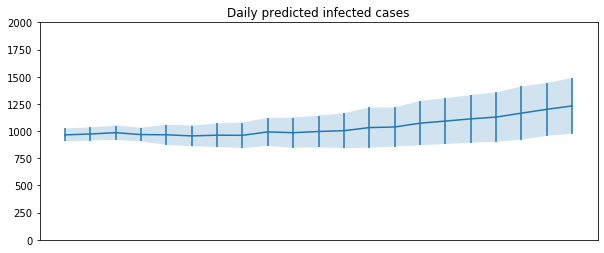

In [87]:
plt.figure(figsize=(10,4))
ax = plt.subplot(1,1,1)
ax.plot(dfPredsT["date"].values, dfPredsT[[i for i in range(10)]].values)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.title("Daily predicted infected cases")
plt.xticks(rotation='vertical')
plt.ylim(0,2000)
plt.show()

plt.figure(figsize=(10,4))
ax = plt.subplot(1,1,1)
ax.errorbar(dfPredsT["date"], 
            dfPredsT[[i for i in range(10)]].mean(axis=1),
            yerr=dfPredsT[[i for i in range(10)]].std(axis=1))
ax.fill_between(dfPredsT["date"],
                dfPredsT[[i for i in range(10)]].mean(axis=1)-dfPredsT[[i for i in range(10)]].std(axis=1),
                dfPredsT[[i for i in range(10)]].mean(axis=1)+dfPredsT[[i for i in range(10)]].std(axis=1),
                alpha=0.2)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.title("Daily predicted infected cases")
plt.xticks(rotation='vertical')
plt.ylim(0,2000)
plt.show()

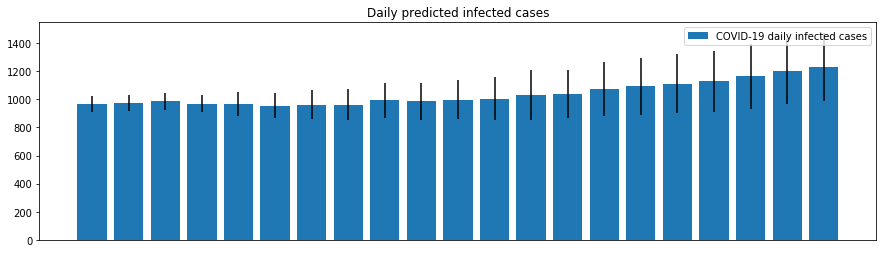

In [88]:
plt.figure(figsize=(15,4))
ax = plt.subplot(1,1,1)
ax.bar(dfPredsT["date"].values, np.mean(dfPredsT[[i for i in range(10)]], axis=1), 
            yerr=np.std(dfPredsT[[i for i in range(10)]], axis=1), label="COVID-19 daily infected cases")
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.title("Daily predicted infected cases")
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

No handles with labels found to put in legend.


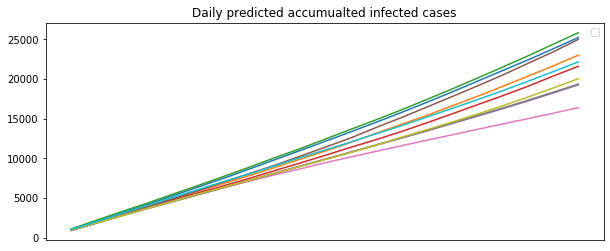

In [89]:
plt.figure(figsize=(10,4))
ax = plt.subplot(1,1,1)
ax.plot(dfPredsT["date"], dfPredsT[[i for i in range(10)]].cumsum())
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.title("Daily predicted accumualted infected cases")
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

No handles with labels found to put in legend.


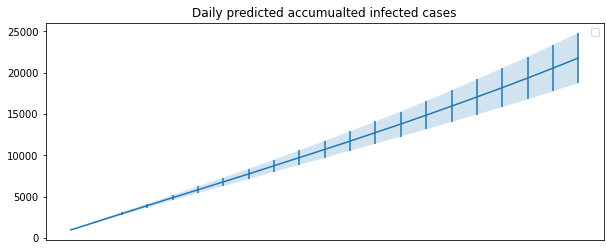

In [90]:
plt.figure(figsize=(10,4))
ax = plt.subplot(1,1,1)
#ax.plot(dfPredsT["date"], dfPredsT[[i for i in range(10)]].cumsum())
ax.errorbar(dfPredsT["date"], 
            dfPredsT[[i for i in range(10)]].cumsum().mean(axis=1),
            yerr=dfPredsT[[i for i in range(10)]].cumsum().std(axis=1))
ax.fill_between(dfPredsT["date"],
                dfPredsT[[i for i in range(10)]].cumsum().mean(axis=1)-dfPredsT[[i for i in range(10)]].cumsum().std(axis=1),
                dfPredsT[[i for i in range(10)]].cumsum().mean(axis=1)+dfPredsT[[i for i in range(10)]].cumsum().std(axis=1),
                alpha=0.2)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.title("Daily predicted accumualted infected cases")
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

In [ ]:
#Forecasting future 100 days!!

In [73]:
#Find rows for future pred
ftest_X = res_test.iloc[-100:,:210].values.reshape(-1,21,10)
ftest_y = res_test.iloc[-100:,[210+(10*i) for i in range(21)]].values.reshape(-1,21)
print(ftest_X.shape, ftest_y.shape)
print(ftest_y[0,:])

(100, 21, 10) (100, 21)
[1425. 1880. 3074. 3460. 3711. 3972. 2698. 2492. 4978. 5705. 5583. 5552.
 5334. 3324. 3009. 5045. 5188. 4879. 4473. 4913. 3190.]


In [74]:
print(np.max(ftest_X),np.min(ftest_X),np.mean(ftest_X),np.std(ftest_X))

5705.0 56.142857142857146 907.3236849910212 1092.3459004720048


In [75]:
# normalize features
for i in range(ftest_X.shape[-1]):

    # normalize features
    ftest_X[:,:,i] = scalers_X[i].transform(ftest_X[:,:,i])

print(ftest_X.shape)
print(np.max(ftest_X),np.min(ftest_X),np.mean(ftest_X),np.std(ftest_X))

(100, 21, 10)
1.0000000000000002 0.10172778561354019 0.4913172839154454 0.22397491076607032


In [ ]:
#Forecasting with single model

Forecast: [[0.55068797 0.56346834 0.565618   0.5703555  0.577487   0.56420726
  0.5881325  0.5593757  0.55922854 0.58058846 0.5552206  0.5563233
  0.5426074  0.5478878  0.5102314  0.5085964  0.50738066 0.486738
  0.4860798  0.4641923  0.4446045 ]]
Forecast: [3156.5022 3228.9924 3241.1853 3268.0564 3308.5063 3233.1836 3368.8877
 3205.779  3204.9443 3326.098  3182.2114 3188.4658 3110.6694 3140.6196
 2927.0325 2917.759  2910.8633 2793.7778 2790.0447 2665.8987 2554.7966]


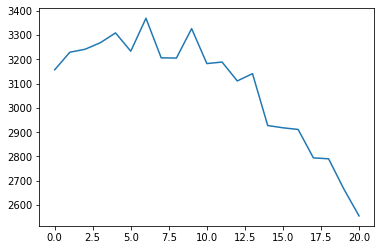

In [52]:
preds = model.predict(ftest_X)
print("Forecast:", preds)
fts = scaler_y.inverse_transform(preds)[0]
print("Forecast:", fts)

plt.plot(range(len(fts)), fts)
plt.show()

In [ ]:
#Forecasting last X days for all models

In [77]:
all_preds = []
for i in range(10):
    print("\nLoading model:", i)
    model = tf.keras.models.load_model("models/"+ fname + "_" + str(i) +'.h5')
    preds = model.predict(ftest_X)
    preds_inv = scaler_y.inverse_transform(preds)
    print(len(preds_inv), np.max(preds_inv), np.min(preds_inv))
    print(preds_inv.shape)
    all_preds.append(preds_inv)



Loading model: 0
100 4645.5034 1070.0245
(100, 21)

Loading model: 1
100 4823.6523 731.50775
(100, 21)

Loading model: 2
100 3791.6023 1127.5348
(100, 21)

Loading model: 3
100 4861.217 619.1388
(100, 21)

Loading model: 4
100 4704.339 986.00323
(100, 21)

Loading model: 5
100 5069.1724 1107.6738
(100, 21)

Loading model: 6
100 4276.6636 518.10284
(100, 21)

Loading model: 7
100 5058.3755 717.7447
(100, 21)

Loading model: 8
100 4924.5347 1104.8083
(100, 21)

Loading model: 9
100 4787.2837 966.5864
(100, 21)


In [94]:
all_preds_aux = np.stack((all_preds))
print(all_preds_aux.shape)
all_preds_aux[:,-1,0]

(10, 100, 21)


array([3285.2256, 2978.8833, 2269.8276, 3247.8098, 3165.3125, 3460.1277,
       2701.7808, 3053.5168, 3218.508 , 3052.4958], dtype=float32)

In [99]:
print(len(all_preds))
len(preds_inv)
print(ftest_X.shape)

all_res = []
for i in range(99,19,-1):
    #print(ftest_X[i].shape)
    if i == 99:
        all_res = all_preds_aux[:,i]
        #print(all_res.shape)
    else:
        #print(ftest_X[i,-1].shape)
        all_res = np.hstack((all_preds_aux[:,i,-1].reshape(10,1),all_res))
        #print(all_res.shape)

print()
print(all_res.shape)
all_res = np.array(all_res)
print(all_res.shape)

10
(100, 21, 10)

(10, 100)
(10, 100)


In [100]:
dfPreds = pd.DataFrame(np.hstack((all_res)).reshape(10,100),columns=["d"+str(i) for i in range(100)])
dfPreds.astype(int).to_csv("preds_infected_cases_basic_100days.csv",index=False)

In [101]:
dfPreds.head()

,d0,d1,d2,d3,d4,d5,d6,d7,d8,d9,...,d90,d91,d92,d93,d94,d95,d96,d97,d98,d99
0,1396.500854,1336.426147,1292.270386,1277.030151,1264.223877,1251.231812,1241.422241,1240.999878,1258.093994,1273.262451,...,2999.697510,2930.066406,2930.172607,2716.385742,2680.207764,2630.200928,2549.442871,2369.356445,2300.048096,2329.684082
1,940.454712,826.792053,749.372131,754.741150,744.109802,731.507751,744.250427,775.355591,819.661682,876.244263,...,2712.118164,2624.721191,2366.187012,2369.412354,2350.209229,2223.354980,2173.977295,2061.475098,1919.527344,1872.092773
2,1164.747314,1151.793091,1148.754395,1190.155884,1204.854736,1217.576416,1241.858521,1266.569336,1283.420044,1321.842163,...,1907.625732,1821.480469,1650.050903,1901.106567,1356.134644,1669.773071,1818.137207,1750.854736,1508.804199,1294.877930
3,1235.594116,1088.954834,970.529419,940.944946,875.184204,789.148804,721.817200,658.572449,640.230957,662.331665,...,3015.176758,2789.425781,2784.150635,2627.301270,2639.552490,2555.058838,2449.098145,2255.391113,2395.224121,2187.526611
4,1279.838257,1200.892334,1145.987427,1196.571533,1212.930664,1201.702515,1200.744751,1199.952637,1203.587280,1225.806763,...,2455.728516,2455.862793,2460.162109,2483.591553,2436.402588,2317.257812,2091.291016,1924.768066,1975.756470,1790.962524


<Figure size 720x288 with 0 Axes>

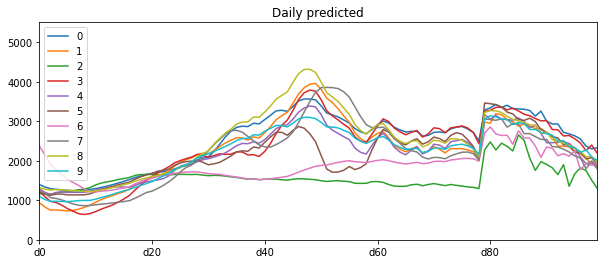

In [102]:
plt.figure(figsize=(10,4))
dfPreds.T.plot(figsize=(10,4))
plt.ylim(0,5500)
plt.title("Daily predicted")
plt.show()